In [1]:
%pylab inline
%load_ext music21.ipython21

Populating the interactive namespace from numpy and matplotlib


In [36]:
from music21 import *
import pandas as pd
import pickle

import seaborn as sns
from latexify import *

import sys
sys.path.append('/home/fl350/bachbot/scripts')
from datasets import standardize_key, extract_SATB

In [3]:
QUANTIZE_QUARTER_NOTE_SUBDIVISION = 4

catalog = stream.Opus()
catalog_transpose = stream.Opus() # transposed to Cmaj/Amin
catalog_transpose_quantize = stream.Opus() # transposed and quantized
for workName in corpus.getBachChorales():
    work = converter.parse(workName)
    firstTS = work.flat.getTimeSignatures()[0]
    if firstTS.ratioString == '4/4': #Filter for every Bach chorale that is in 4/4
        try:
            work = extract_SATB(work)
            transposed = standardize_key(work)
            catalog.append(work)
            transposed = standardize_key(work)
            catalog_transpose.append(transposed)
            catalog_transpose_quantize.append(transposed.quantize((2,)))
        except analysis.discrete.DiscreteAnalysisException:
            continue

In [4]:
def exampleIter():
    for s in catalog:
        # find a piece which will be affected by quantization
        if len(filter(lambda x: 0.125 == x.duration.quarterLength, s.flat.notesAndRests)) > 0:
            yield s

In [5]:
#it = exampleIter()
#s = it.next()
#s.metadata.title
s = extract_SATB(corpus.parse('bwv185.6'))
print s.metadata.title

bwv185.6.mxl


Standard music score notation

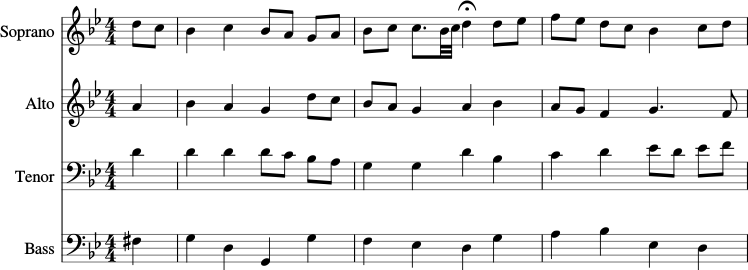

In [6]:
s_subset = s.measures(0, 3)
s_subset.write('musicxml.png', 'bwv185-6-original-score.xml')
s_subset.show()

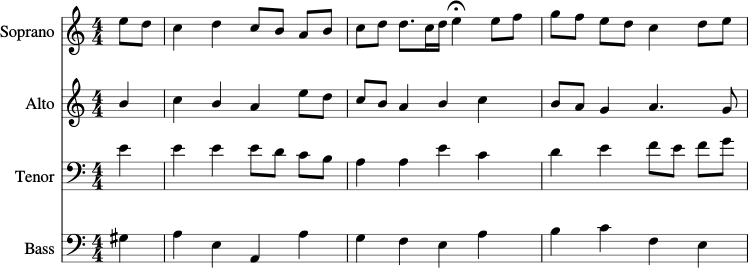

In [7]:
s_subset_processed = standardize_key(s_subset).quantize((QUANTIZE_QUARTER_NOTE_SUBDIVISION,))
s_subset_processed.write('musicxml.png', 'bwv185-6-preproc-score.xml')
s_subset_processed.show()

Piano roll representation

In [8]:
def plot_piano_roll(ax1, s):
    g = graph.PlotHorizontalBarPitchSpaceOffset(s)
    data, xTicks, _ = g._extractData()

    yPos = 0
    xPoints = [] # store all to find min/max
    yTicks = [] # a list of label, value pairs

    #colors = sns.color_palette("muted")
    colors = sns.color_palette("husl", 12)

    keys = []
    i = 0
    for i, (key, points) in enumerate(data):
        keys.append(key)
        if len(points) > 0:
            yrange = (yPos + 1, 1)
            ax1.broken_barh(points,
                            yrange,
                            facecolor=colors[i%len(colors)],
                            alpha=0.8)
            for xStart, xLen in points:
                xEnd = xStart + xLen
                for x in [xStart, xEnd]:
                    if x not in xPoints:
                        xPoints.append(x)
        yTicks.append([yPos + 1 * .5, key])
        yPos += 1
        i += 1

    xMin = min(xPoints)
    xMax = max(xPoints) 
    ax1.set_ylim(0, len(keys) * 1)
    ax1.set_xlim(xMin, xMax)
    ax1.set_yticks(map(lambda x: x+1, zip(*yTicks)[0]))
    ax1.set_yticklabels(zip(*yTicks)[1])
    ax1.set_xticks(zip(*xTicks)[0])
    ax1.set_xticklabels(zip(*xTicks)[1])
    ax1.set_title('Piano roll')
    ax1.set_xlabel('Measure number')
    ax1.set_ylabel('Pitch')

    return ax1

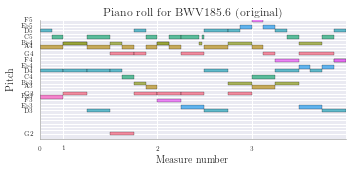

In [56]:
latexify(fig_width=5, fig_height=2.5, tick_labelsize=6)
fig, ax = plt.subplots(1, 1)

plot_piano_roll(ax, s_subset)
ax.set_title('Piano roll for BWV185.6 (original)')

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('bwv185-6-original-piano-roll.pgf', bbox_inches='tight', dpi=300)

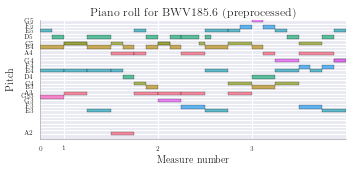

In [55]:
latexify(fig_width=5, fig_height=2.5, tick_labelsize=6)
fig, ax = plt.subplots(1, 1)

plot_piano_roll(ax, s_subset_processed)
ax.set_title('Piano roll for BWV185.6 (preprocessed)'.format(4*QUANTIZE_QUARTER_NOTE_SUBDIVISION))

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('bwv185-6-preproc-piano-roll.pgf', bbox_inches='tight', dpi=300)

Meter profile of JCB: very regular at quarter or eighth positions within a measure, partially justifies quantization

In [9]:
#Count usages
allbeats = list();
for p in catalog.flat.notes:
    for counter in range(len(p.pitches)):
        allbeats.append(p.beat - 1)

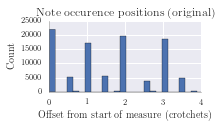

In [41]:
latexify(columns=1)
fig, ax = plt.subplots(1, 1)

ax.hist(allbeats, bins=32, range=(0,5))
ax.set_xlabel("Offset from start of measure (crotchets)")
ax.set_ylabel("Count")
ax.set_title('Note occurence positions (original)')
ax.set_xlim(0,4)
ax.set_xticks(np.arange(0, 5, 1.0))

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('meter-usage-original.pgf', bbox_inches='tight', dpi=300)

In [10]:
#Count usages
allbeats_quantized = list();
for p in catalog_transpose_quantize.flat.notes:
    for counter in range(len(p.pitches)):
        allbeats_quantized.append(p.beat - 1)

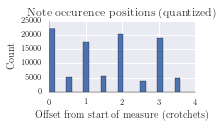

In [42]:
latexify(columns=1)
fig, ax = plt.subplots(1, 1)

ax.hist(allbeats_quantized, bins=32, range=(0,5))
ax.set_xlabel("Offset from start of measure (crotchets)")
ax.set_ylabel("Count")
ax.set_title('Note occurence positions (quantized)')
ax.set_xlim(0,4)
ax.set_xticks(np.arange(0, 5, 1.0))

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('meter-usage-quantized.pgf', bbox_inches='tight', dpi=300)

Note lengths: justify quantization to 8th or 16th notes

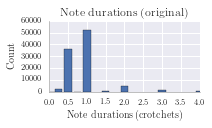

In [28]:
latexify(columns=1)
fig, ax = plt.subplots(1, 1)

data, xTicks, _ = graph.PlotHistogramQuarterLength(catalog)._extractData()
ax.bar(*zip(*data), width=0.2, align='center')
ax.set_xlabel('Note durations (crotchets)')
ax.set_xlim(0,4)
ax.set_ylabel('Count')
ax.set_title('Note durations (original)')

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('note-lengths-original.pgf', bbox_inches='tight', dpi=300)

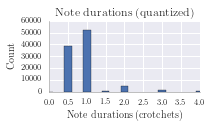

In [27]:
latexify(columns=1)
fig, ax = plt.subplots(1, 1)

data, xTicks, _ = graph.PlotHistogramQuarterLength(catalog_transpose_quantize)._extractData()
ax.bar(*zip(*data), width=0.2, align='center')
ax.set_xlabel('Note durations (crotchets)')
ax.set_xlim(0,4)
ax.set_ylabel('Count')
ax.set_title('Note durations (quantized)')

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('note-lengths-quantized.pgf', bbox_inches='tight', dpi=300)

Pitch usage profile

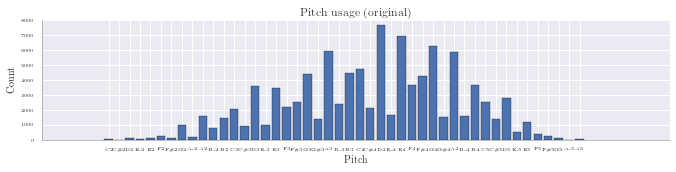

In [53]:
fig, ax = plt.subplots(1, 1)
latexify(fig_width=7, fig_height=2.5, tick_labelsize=5)

data, xTicks, _ = graph.PlotHistogramPitchSpace(catalog)._extractData()
ax.bar(*zip(*data))
ax.set_xticks(zip(*xTicks)[0])
ax.set_xticklabels(map(lambda x: x.replace('#', '\#'), zip(*xTicks)[1]))
ax.set_xlabel('Pitch')
ax.set_ylabel('Count')
ax.set_title('Pitch usage (original)')

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('pitch-usage-original.pgf', bbox_inches='tight', dpi=300)

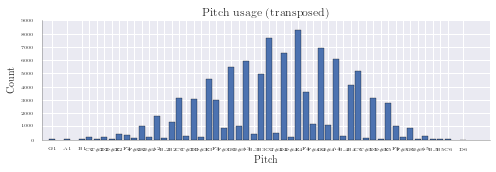

In [54]:
fig, ax = plt.subplots(1, 1)
latexify(fig_width=7, fig_height=2.5, tick_labelsize=5)

data, xTicks, _ = graph.PlotHistogramPitchSpace(catalog_transpose_quantize)._extractData()
ax.bar(*zip(*data))
ax.set_xticks(zip(*xTicks)[0])
ax.set_xticklabels(map(lambda x: x.replace('#', '\#'), zip(*xTicks)[1]))
ax.set_xlabel('Pitch')
ax.set_ylabel('Count')
ax.set_title('Pitch usage (transposed)')

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('pitch-usage-preproc.pgf', bbox_inches='tight', dpi=300)

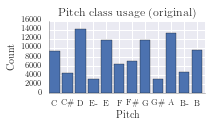

In [32]:
fig, ax = plt.subplots(1, 1)
latexify(columns=1)

data, xTicks, _ = graph.PlotHistogramPitchClass(catalog)._extractData()
ax.bar(*zip(*data))
ax.set_xticks(zip(*xTicks)[0])
ax.set_xticklabels(map(lambda x: x.replace('#', '\#'), zip(*xTicks)[1]))
ax.set_xlabel('Pitch')
ax.set_ylabel('Count')
ax.set_title('Pitch class usage (original)')

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('pitch-class-usage-original.pgf', bbox_inches='tight', dpi=300)

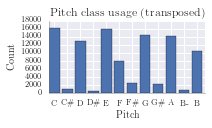

In [33]:
fig, ax = plt.subplots(1, 1)
latexify(columns=1)

data, xTicks, _ = graph.PlotHistogramPitchClass(catalog_transpose_quantize)._extractData()
ax.bar(*zip(*data))
ax.set_xticks(zip(*xTicks)[0])
ax.set_xticklabels(map(lambda x: x.replace('#', '\#'), zip(*xTicks)[1]))
ax.set_xlabel('Pitch')
ax.set_ylabel('Count')
ax.set_title('Pitch class usage (transposed)')

format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('pitch-class-usage-preproc.pgf', bbox_inches='tight', dpi=300)

Zipf distribution over (Note,Duration) tuples

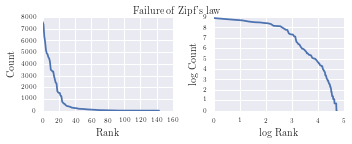

In [50]:
import pandas as pd

data, xTicks, yTicks = graph.PlotScatterWeightedPitchClassQuarterLength(catalog)._extractData()
df = pd.DataFrame(data, columns=('x', 'y', 'sz'))
counts = df['sz'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2)
latexify(columns=2, fig_height=2)

ax1.plot(range(len(counts)), counts)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Count')

ax2.plot(log(range(len(counts))), log(counts))
ax2.set_xlabel('log Rank')
ax2.set_ylabel('log Count')

fig.suptitle("Failure of Zipf's law")
format_axes(ax)
fig.tight_layout()
fig.show()
fig.savefig('zipf-law-note-tuples.pgf', bbox_inches='tight', dpi=300)

# Results over synthesized SATB corpus